In [2]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../utils_mapping.R')
})


library(biomaRt)

library(GEOquery)


# Load data

## Expression

In [ ]:
datadir <- '/data/srlab/ik936/Roche/data/mouse/GSE132771_RAW'
fnames <- list.files(datadir, pattern = 'Bleo|UT\\d')
sample_names <- unique(gsub('(GSM\\d+_.+?_.+?)_.*', '\\1', fnames))


In [ ]:
sumOverRowNames <- function(X) {
    name_factors <- factor(row.names(X))
    res <- sumGroups(X, name_factors)
    row.names(res) <- levels(name_factors)[1:nrow(res)]
    colnames(res) <- colnames(X)
    return(res)
}


In [ ]:
exprs_list <- sample_names %>% map(function(sample_name) {
    message(sample_name)
    barcode.loc <- sprintf('%s/%s_barcodes.tsv.gz', datadir, sample_name)
    gene.loc <- sprintf('%s/%s_genes.tsv.gz', datadir, sample_name)
    matrix.loc <- sprintf('%s/%s_matrix.mtx.gz', datadir, sample_name)
    data <- readMM(file = matrix.loc) %>% as("dgCMatrix")
    cell.names <- readLines(barcode.loc)
    cell.names <- gsub("-1$", "", cell.names)    
    cell.names <- paste(cell.names, sample_name, sep = '_')
    gene.names <- fread(gene.loc, header = FALSE)$V2
    row.names(data) <- gene.names
    colnames(data) <- cell.names
    return(as(sumOverRowNames(data), "dgCMatrix"))
})

exprs_raw <- Reduce(Matrix::cbind2, exprs_list)


In [ ]:
dim(exprs_raw)

## Metadata

In [ ]:
geo_meta <- GEOquery::getGEO('GSE132771')$`GSE132771-GPL21103_series_matrix.txt.gz`@phenoData@data %>% 
    dplyr::select(title, geo_accession, matches(':ch1$')) %>% 
    janitor::clean_names()

In [49]:
geo_meta

,title,geo_accession,genotype_variation_ch1,individual_identifier_ch1,sorted_cell_type_ch1,treatment_ch1
,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>
GSM3891612,Bleo1_GFPp,GSM3891612,Col1a1-GFP reporter,Bleomycin1,GFP+,Bleomycin
GSM3891613,Bleo2_GFPp,GSM3891613,Col1a1-GFP reporter,Bleomycin2,GFP+,Bleomycin
GSM3891614,Bleo1_GFPn,GSM3891614,Col1a1-GFP reporter,Bleomycin1,GFP-,Bleomycin
GSM3891615,Bleo2_GFPn,GSM3891615,Col1a1-GFP reporter,Bleomycin2,GFP-,Bleomycin
GSM3891616,UT1_GFPp,GSM3891616,Col1a1-GFP reporter,Untreted1,GFP+,Untreated
GSM3891617,UT2_GFPp,GSM3891617,Col1a1-GFP reporter,Untreted2,GFP+,Untreated
GSM3891618,UT1_GFPn,GSM3891618,Col1a1-GFP reporter,Untreted1,GFP-,Untreated
GSM3891619,UT2_GFPn,GSM3891619,Col1a1-GFP reporter,Untreted2,GFP-,Untreated


Xie et al 

In [24]:
# library(openxlsx)

# fname <- '/data/srlab/ik936/Roche/data/mouse/GSE104154_cell_type_annotation_d0_d21.xlsx'

# meta_data <- openxlsx::getSheetNames(fname) %>% map(function(worksheet_name) openxlsx::readWorkbook(fname, worksheet_name))
# names(meta_data) <- openxlsx::getSheetNames(fname)

# meta_data <- list(
#     bleo = meta_data$d21_cell_type_anno %>% 
#         dplyr::mutate(barcode_suffix = as.integer(gsub('^.*(\\d)$', '\\1', Barcode))) %>% 
#         dplyr::left_join(meta_data$sample_anno) %>% 
#         dplyr::select(-barcode_suffix),
#     ctrl = meta_data$d0_cell_type_anno %>% 
#         dplyr::mutate(barcode_suffix = as.integer(gsub('^.*(\\d)$', '\\1', Barcode))) %>% 
#         dplyr::left_join(meta_data$sample_anno) %>% 
#         dplyr::select(-barcode_suffix)
# ) %>% 
#     bind_rows(.id = 'Status') %>% 
#     dplyr::select(CellID = Barcode, CellType = defined, Status, FACS = sample_name)


In [74]:
head(colnames(exprs_raw))

[1] "AAACCTGAGAGGTAGA_GSM3891612_Bleo1_GFPp"
[2] "AAACCTGAGCTGAAAT_GSM3891612_Bleo1_GFPp"
[3] "AAACCTGAGTTAACGA_GSM3891612_Bleo1_GFPp"
[4] "AAACCTGCAATGCCAT_GSM3891612_Bleo1_GFPp"
[5] "AAACCTGCAGCAGTTT_GSM3891612_Bleo1_GFPp"
[6] "AAACCTGCAGGGTACA_GSM3891612_Bleo1_GFPp"

In [104]:
mito_genes <- grep("^MT-", rownames(exprs_raw), value = TRUE, ignore.case = TRUE)
meta_data <- tibble(
#     CellID = gsub('(^.*?)_(.*?)_(.*)$', '\\1', colnames(exprs_raw)),
    CellID = colnames(exprs_raw),
    LibraryID = gsub('(^.*?)_(.*?)_(.*)$', '\\2', colnames(exprs_raw)),
    nGene = Matrix::colSums(exprs_raw != 0), 
    nUMI = Matrix::colSums(exprs_raw), 
    percent_mito = Matrix::colSums(exprs_raw[mito_genes, ])/Matrix::colSums(exprs_raw)
) %>% 
    dplyr::left_join(geo_meta, by = c('LibraryID' = 'geo_accession')) %>% 
    dplyr::rename(
        Genotype = genotype_variation_ch1,
        FACS = sorted_cell_type_ch1, 
        Treatment = treatment_ch1
    )


In [105]:
head(meta_data)

CellID,LibraryID,nGene,nUMI,percent_mito,title,Genotype,individual_identifier_ch1,FACS,Treatment
<chr>,<chr>,<int>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>
AAACCTGAGAGGTAGA_GSM3891612_Bleo1_GFPp,GSM3891612,2879,8615,0.0319210679,Bleo1_GFPp,Col1a1-GFP reporter,Bleomycin1,GFP+,Bleomycin
AAACCTGAGCTGAAAT_GSM3891612_Bleo1_GFPp,GSM3891612,1140,2185,0.0224256293,Bleo1_GFPp,Col1a1-GFP reporter,Bleomycin1,GFP+,Bleomycin
AAACCTGAGTTAACGA_GSM3891612_Bleo1_GFPp,GSM3891612,1685,3084,0.0333981842,Bleo1_GFPp,Col1a1-GFP reporter,Bleomycin1,GFP+,Bleomycin
AAACCTGCAATGCCAT_GSM3891612_Bleo1_GFPp,GSM3891612,2109,5693,0.0203759002,Bleo1_GFPp,Col1a1-GFP reporter,Bleomycin1,GFP+,Bleomycin
AAACCTGCAGCAGTTT_GSM3891612_Bleo1_GFPp,GSM3891612,85,3771,0.0002651816,Bleo1_GFPp,Col1a1-GFP reporter,Bleomycin1,GFP+,Bleomycin
AAACCTGCAGGGTACA_GSM3891612_Bleo1_GFPp,GSM3891612,1962,4982,0.0272982738,Bleo1_GFPp,Col1a1-GFP reporter,Bleomycin1,GFP+,Bleomycin


## QC

Picking joint bandwidth of 0.0319



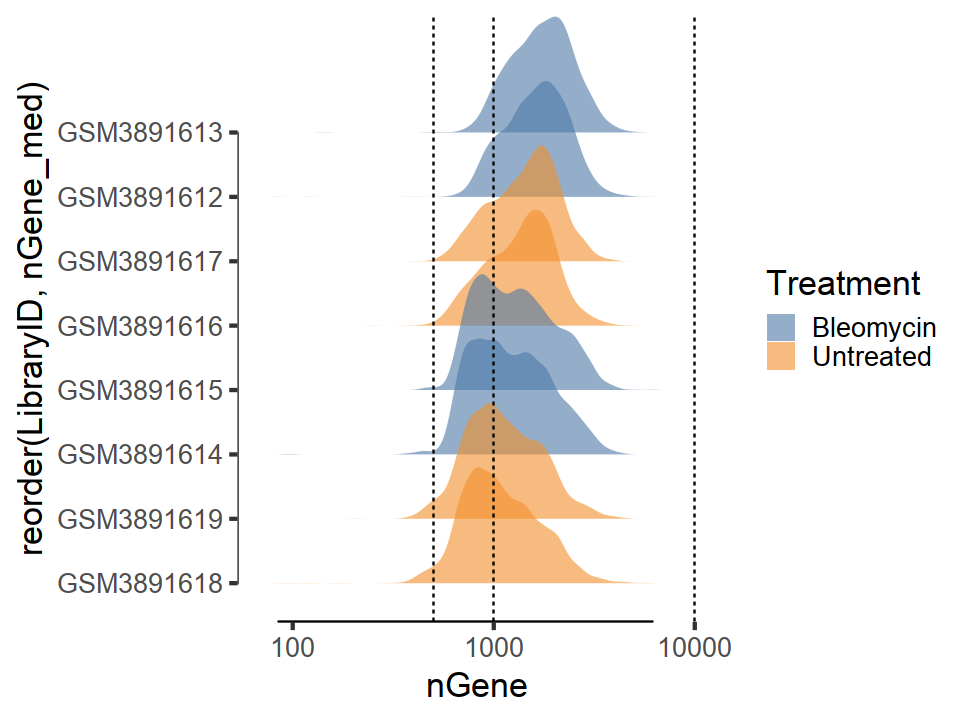

In [106]:
fig.size(6, 8)
data.table(meta_data)[, nGene_med := median(nGene), by = LibraryID][] %>% 
    ggplot(aes(nGene, reorder(LibraryID, nGene_med), fill = Treatment)) + 
        geom_density_ridges2(aes(height = ..ndensity..), alpha = .6, color = NA) + 
        theme_tufte(base_size = 20) + geom_rangeframe(color = 'black') + 
        scale_x_continuous(trans = 'log10') + 
        geom_vline(xintercept = c(500, 1e3, 1e4), linetype = 2) + 
        scale_fill_tableau() + 
        NULL


Picking joint bandwidth of 0.00206

Warning message:
“Removed 34 rows containing non-finite values (stat_density_ridges).”


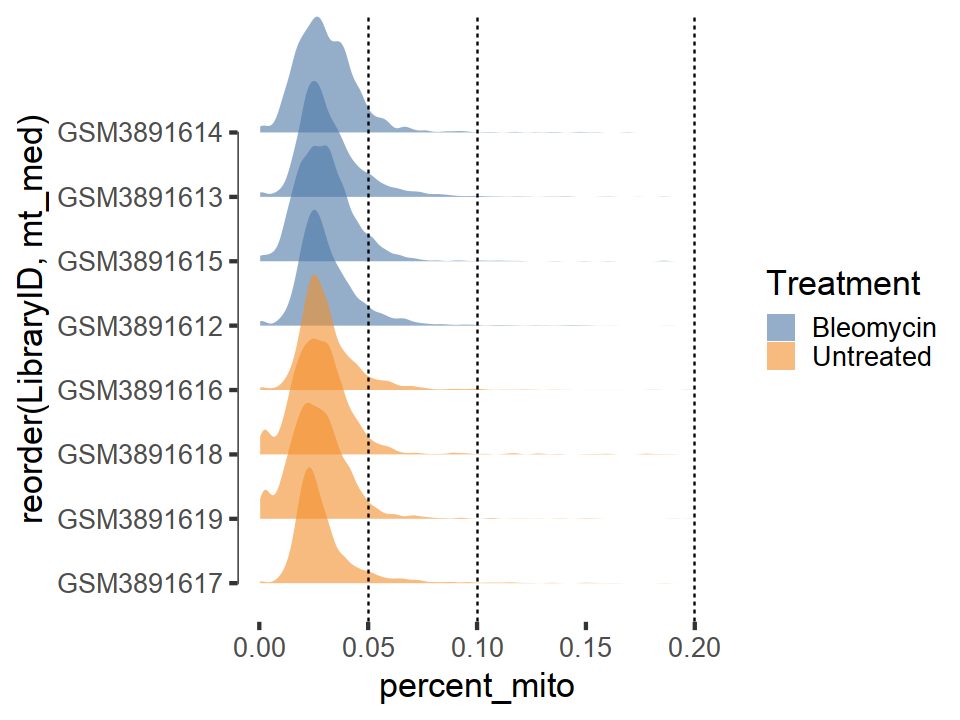

In [107]:
fig.size(6, 8)
data.table(meta_data)[, mt_med := median(percent_mito), by = LibraryID][] %>% 
    ggplot(aes(percent_mito, reorder(LibraryID, mt_med), fill = Treatment)) + 
        geom_density_ridges2(aes(height = ..ndensity..), alpha = .6, color = NA) + 
        theme_tufte(base_size = 20) + geom_rangeframe(color = 'black') + 
#         scale_x_continuous(trans = 'log10') + 
        geom_vline(xintercept = c(.05, .1, .2), linetype = 2) + 
        xlim(0, .2) + 
        scale_fill_tableau() + 
        NULL


In [108]:
meta_data <- meta_data %>% 
    subset(nGene > 500 & percent_mito < .05)

In [109]:
exprs_raw <- exprs_raw[, meta_data$CellID]

# Call out fibroblasts

In [110]:
# obj <- readRDS('/data/srlab/ik936/Roche/data/cache/lung_obj_mouse_all.rds')

## Create object

start filter

Warning message in create_object(exprs_raw, meta_data):
“weights not initialized in metadata. Setting all to 1.”
start normalization

start vargenes

start pca

start UMAP

Warning message:
“invalid uid value replaced by that for user 'nobody'”
Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10

Warning message:
“invalid uid value replaced by that for user 'nobody'”


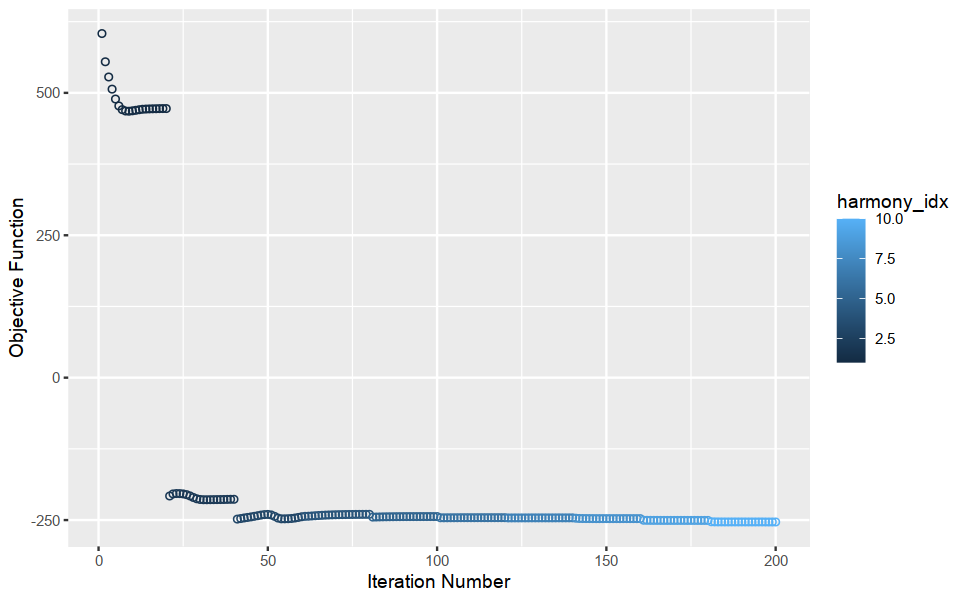

In [111]:
fig.size(5, 8)
set.seed(1)
obj <- create_object(exprs_raw, meta_data) %>% 
    do_harmony(
        'LibraryID', theta=0.5, 
        max.iter.harmony=4, max.iter.cluster=20,
        epsilon.cluster = -Inf, epsilon.harmony = -Inf, 
#         weights = m$weight,
        plot_convergence = TRUE
    ) %>% 
    do_cluster(c(.1, .2, .3, .4))


Warning message:
“Ignoring unknown parameters: label.size”
Warning message:
“Ignoring unknown parameters: label.size”


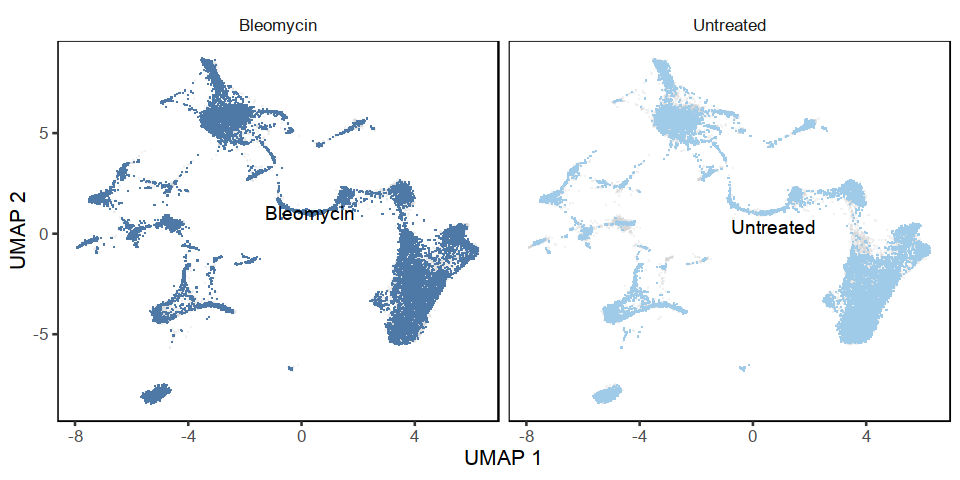

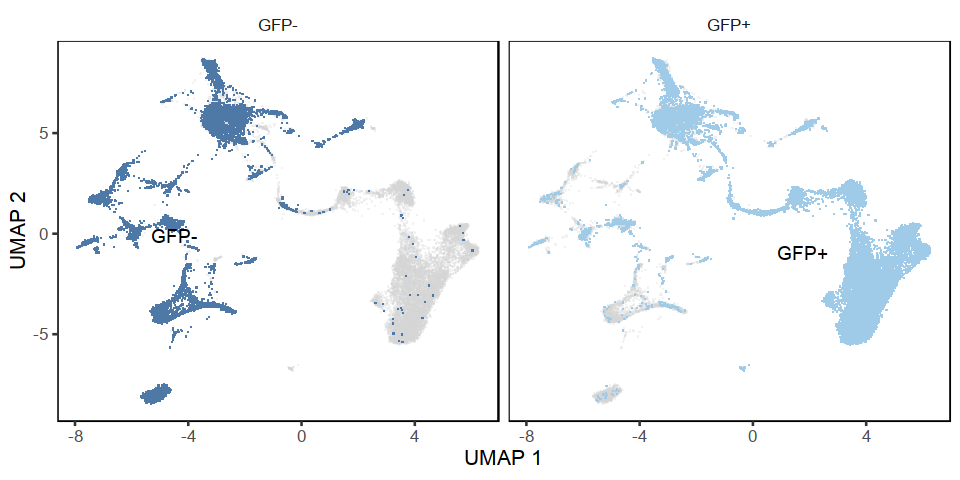

In [221]:
fig.size(4, 8)
do_scatter(obj$umap_after, obj$meta_data, 'Treatment', quo(Treatment))
do_scatter(obj$umap_after, obj$meta_data, 'FACS', quo(FACS))


## Lineage

In [6]:
lineage_markers <- list(
#     epithelial = c('EPCAM', 'CDH1'),
    endothelial = c('VWF', 'NOTCH4', 'PODXL'),
    mural = c('NOTCH3', 'ACTA2', 'MCAM', 'MYH11'),
    fibroblast = c('PDGFRA', 'PDPN', 'ABCA8', 'COL1A1'),
    haematopoietic = c('PTPRC', 'CD3E', 'CD79', 'LYVE1')
#     glial = c('CRYAB', 'S100B')
) %>% 
    map(stringr::str_to_sentence)


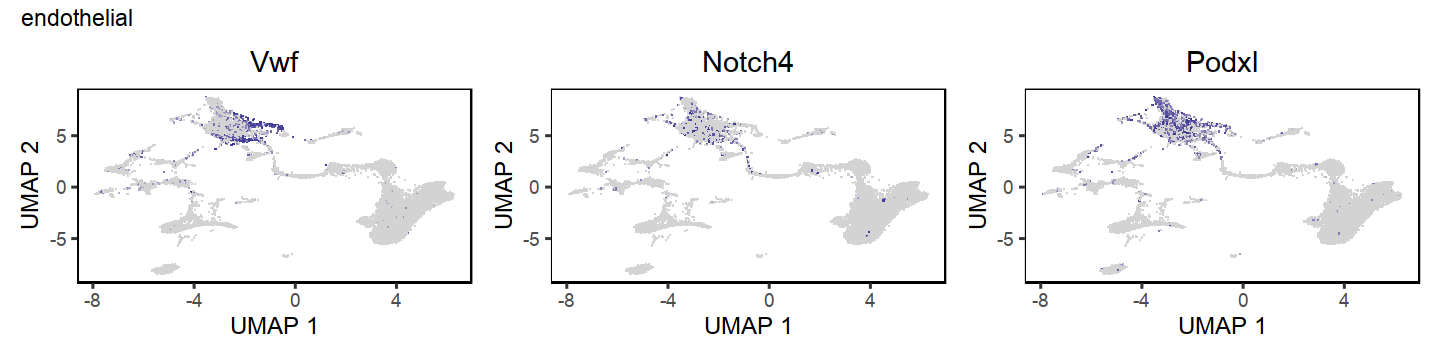

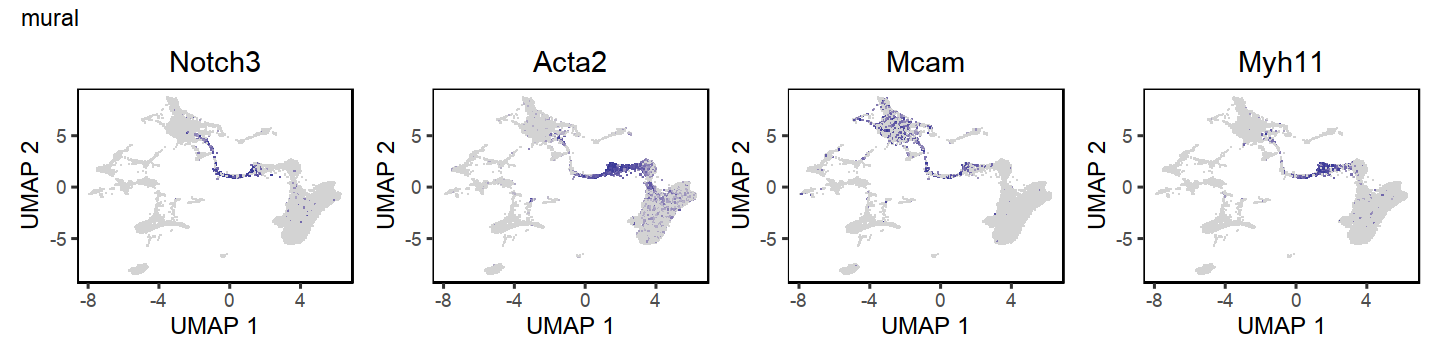

[[1]]

[[2]]

[[3]]

[[4]]


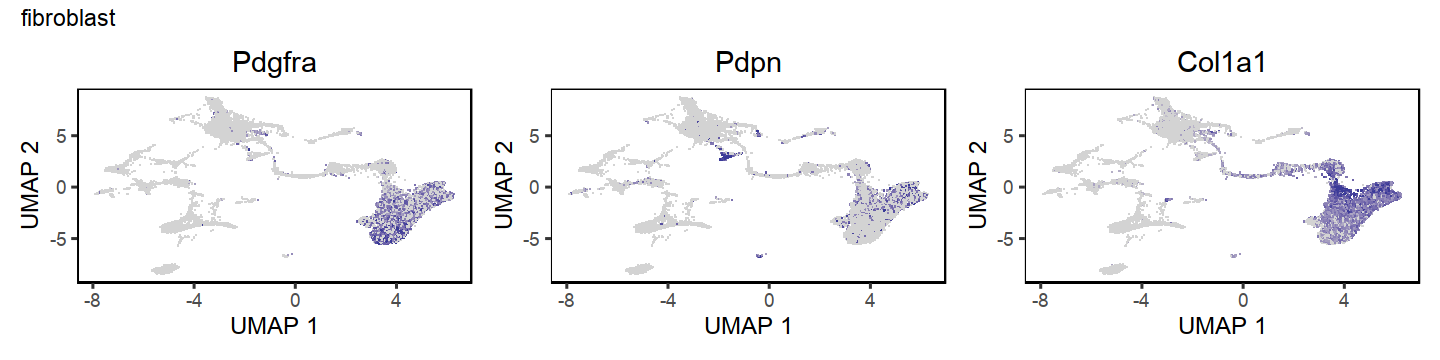

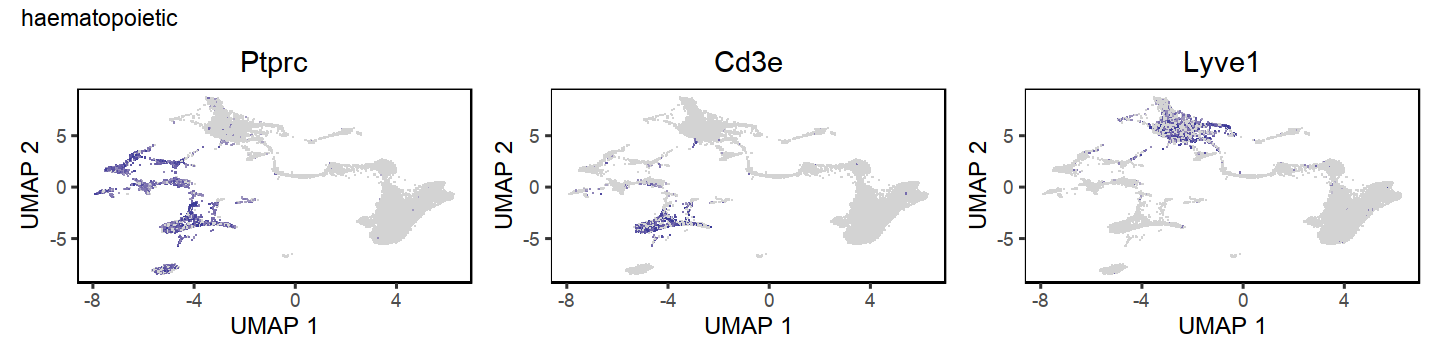

In [7]:
fig.size(3, 12)
with(obj, {
    lapply(names(lineage_markers), function(group) {
        plotFeatures(exprs_norm, umap_after,
                     intersect(lineage_markers[[group]], row.names(exprs_norm)), 
                     qhi = .99, no_guide = TRUE) + 
            plot_annotation(title = group)
    })    
})


In [127]:
# top_markers(obj$markers$res1)

Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”
Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”
Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”
Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”


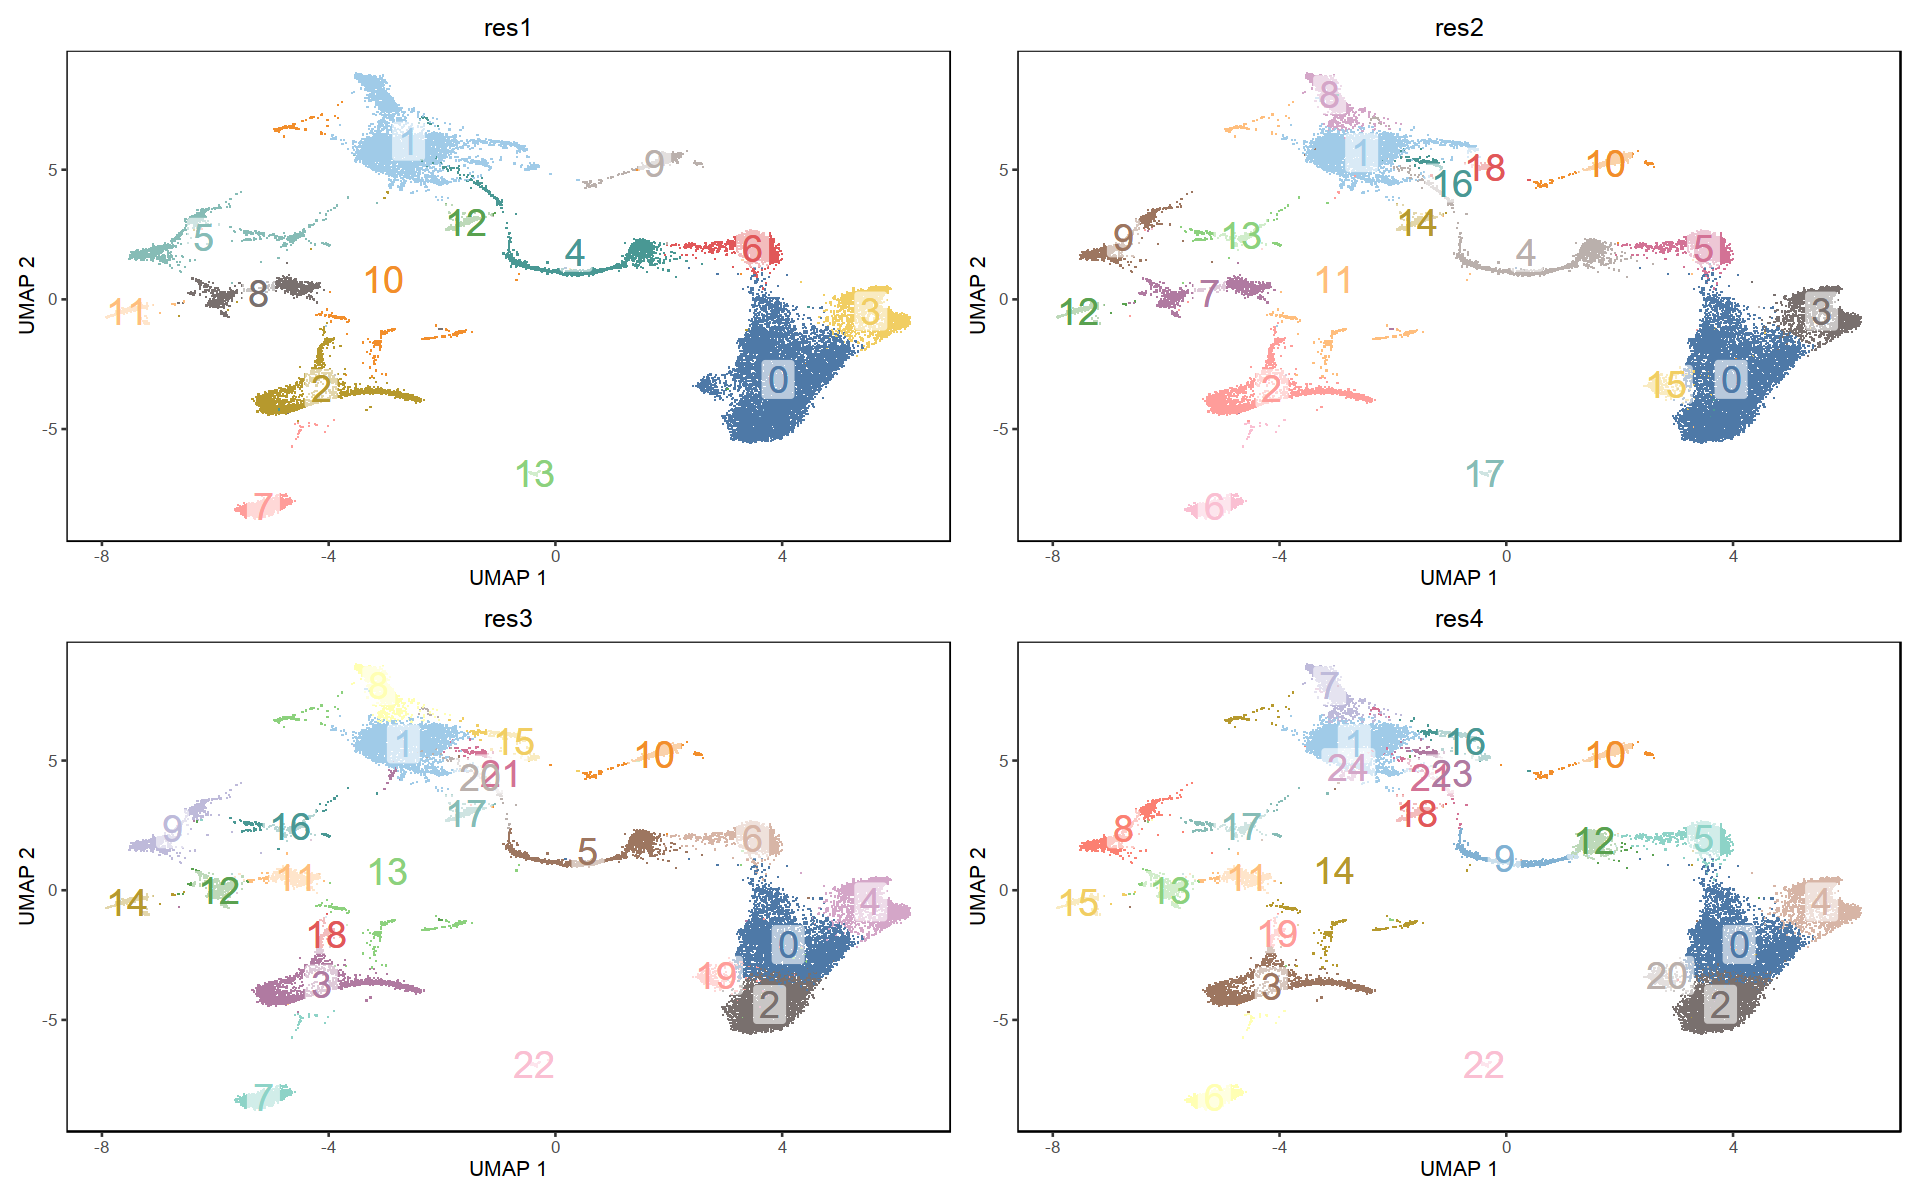

In [8]:
fig.size(10, 16)
plot_clusters(obj, 'umap_after')

In [122]:
obj$meta_data$lineage <- case_when(
    obj$clusters_df$res1 %in% c('1') ~ 'endothelial',
    obj$clusters_df$res1 %in% c('6') ~ 'myofibroblast',
    obj$clusters_df$res1 %in% c('0', '3') ~ 'fibroblast',
    obj$clusters_df$res1 %in% c('4') ~ 'mural',
    obj$clusters_df$res1 %in% c('11', '2', '5', '7', '8') ~ 'hematopoietic',
    TRUE ~ 'UNKNOWN'
)


Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”


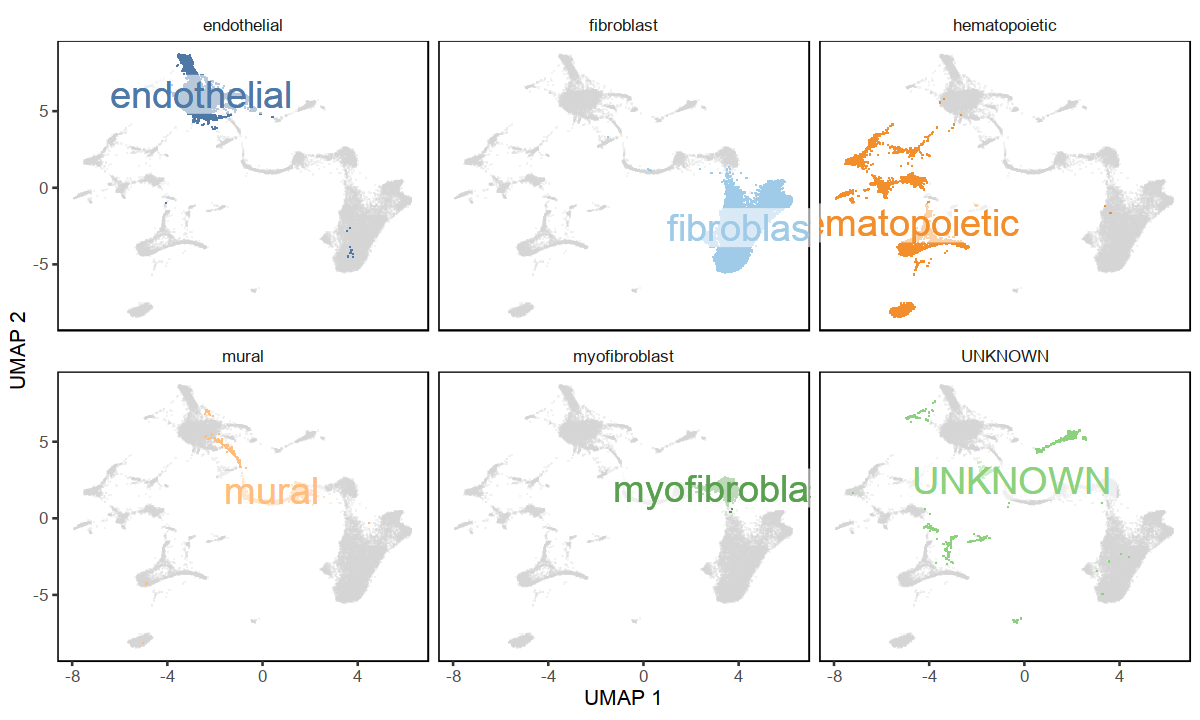

In [4]:
fig.size(6, 10)
# fig.size(5, 8)
do_scatter(obj$umap_after, obj$meta_data, 'lineage', quo(lineage), pt_size = 8, nrow = 2)


All fibroblasts are GFP$^+$!!!! 

Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”


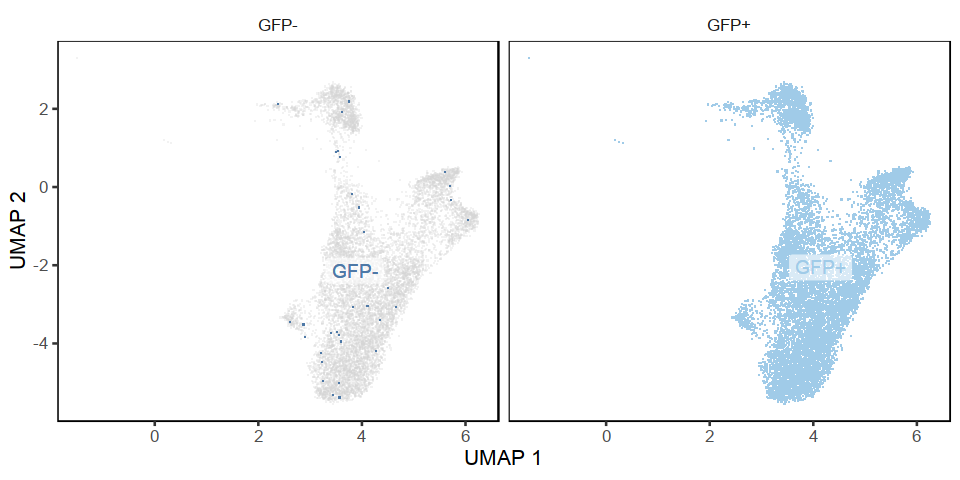

In [5]:
fig.size(4, 8)
# idx_stromal <- grep('fibroblast|endoth', obj$meta_data$lineage)
idx_stromal <- grep('fibroblast', obj$meta_data$lineage)
do_scatter(obj$umap_after[idx_stromal, ], obj$meta_data[idx_stromal, ], 'FACS', quo(FACS))


## Map exprs_raw to human genes

In [128]:
human_genes <- rownames(readRDS('/data/srlab/ik936/Roche/data/cache/lung_obj_stromal.rds')$exprs_raw)



In [130]:
obj$exprs_raw_hs <- map_species(obj$exprs_raw, human_genes, from='mouse', to='human', orthologs_table=NULL, round_fxn=identity)


No orthologues DF provided, pulling data from Biomart



In [131]:
dim(obj$exprs_raw_hs)

[1] 16858 23828

In [132]:
dim(obj$exprs_raw)

[1] 27933 23828

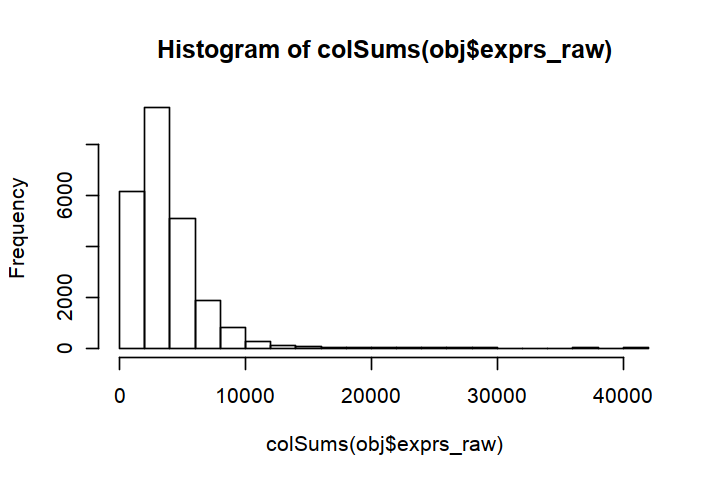

In [133]:
fig.size(4, 6)
hist(colSums(obj$exprs_raw))

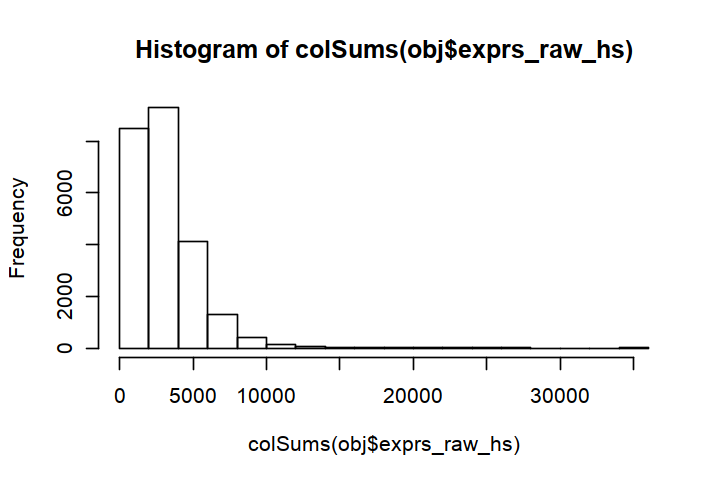

In [134]:
fig.size(4, 6)
hist(colSums(obj$exprs_raw_hs))

# Cache

In [9]:
saveRDS(obj, '/data/srlab/ik936/Roche/data/cache/lung_obj_mouse_stromal.rds')

In [3]:
obj <- readRDS('/data/srlab/ik936/Roche/data/cache/lung_obj_mouse_stromal.rds')